In [ ]:
#install statsmodels, already installed
#%pip install --user statsmodels

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

## Import data from CSV File

Below we read in several years of AAPL data. We then modify the dataframe to set the date as the index.

In [30]:
df = pd.read_csv('C:/users/Trader/Dropbox/Quant Trading/AAPL.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

print(df.shape)

df.head(30)

(2768, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-22,12.577143,12.857142,12.260000,12.622857,10.983161,352382100
2009-01-23,12.402857,12.838572,12.357142,12.622857,10.983161,190942500
2009-01-26,12.694285,12.995714,12.614285,12.805715,11.142265,173059600
2009-01-27,12.884286,13.078571,12.820000,12.961429,11.277751,154509600
2009-01-28,13.160000,13.571428,13.071428,13.457143,11.709072,215351500
2009-01-29,13.298572,13.477143,13.228572,13.285714,11.559913,148182300
2009-01-30,13.228572,13.374286,12.858571,12.875714,11.203172,162869700
2009-02-02,12.728572,13.142858,12.700000,13.072857,11.374706,139561800
2009-02-03,13.131429,13.340000,12.897142,13.282857,11.557426,149827300


## Prepare data for ARIMA

Rather than looking at our data on a daily level, we're going to look at it on a weekly level. The cell below resamples the data in that manner. Each row here is the average price over the previous week.

In [31]:
df_week = df.resample('w').mean()
df_week = df_week[['Adj Close']]

df_week = df_week.rename(columns={"Adj Close" : "Close"})

df_week.head()

,Close
Date,
2009-01-25,10.983161
2009-02-01,11.378435
2009-02-08,11.789122
2009-02-15,12.320381
2009-02-22,11.520758


We need to difference the data to make it stationary. First, we create a column for weekly returns and take the log of those returns to normalize large moves. Then we check a plot of that to make sure it is stationary and we have removed trends. Finally, we drop the 'Close' column to just work with the adjusted return data.

In [32]:
df_week['Return'] = np.log(df_week['Close']).diff()
df_week.head()

,Close,Return
Date,,
2009-01-25,10.983161,NaN
2009-02-01,11.378435,0.035357
2009-02-08,11.789122,0.035457
2009-02-15,12.320381,0.044078
2009-02-22,11.520758,-0.067104


In [33]:
df_week.dropna(inplace=True)

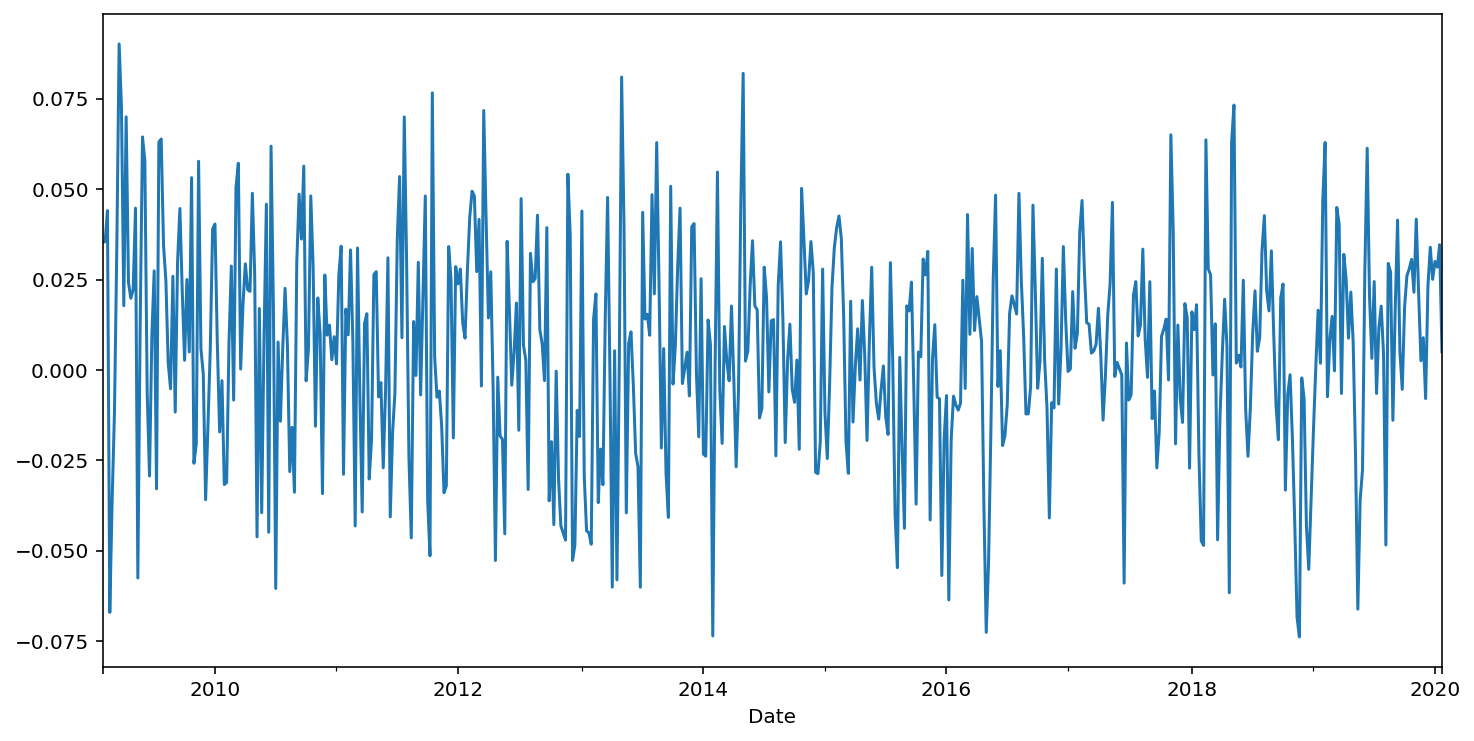

In [34]:
df_week.Return.plot(kind='line', figsize=(12,6));

In [35]:
udiff = df_week.drop(['Close'], axis=1)
udiff.head()

,Return
Date,
2009-02-01,0.035357
2009-02-08,0.035457
2009-02-15,0.044078
2009-02-22,-0.067104
2009-03-01,-0.036399


## Test for data stationarity

We're going to use the Dickey-Fuller test to check for stationarity. We want to make sure we removed the effect of any trends or seasonality.

In [37]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [38]:
mov_avg = udiff.rolling(20).mean()
mov_std = udiff.rolling(20).std()

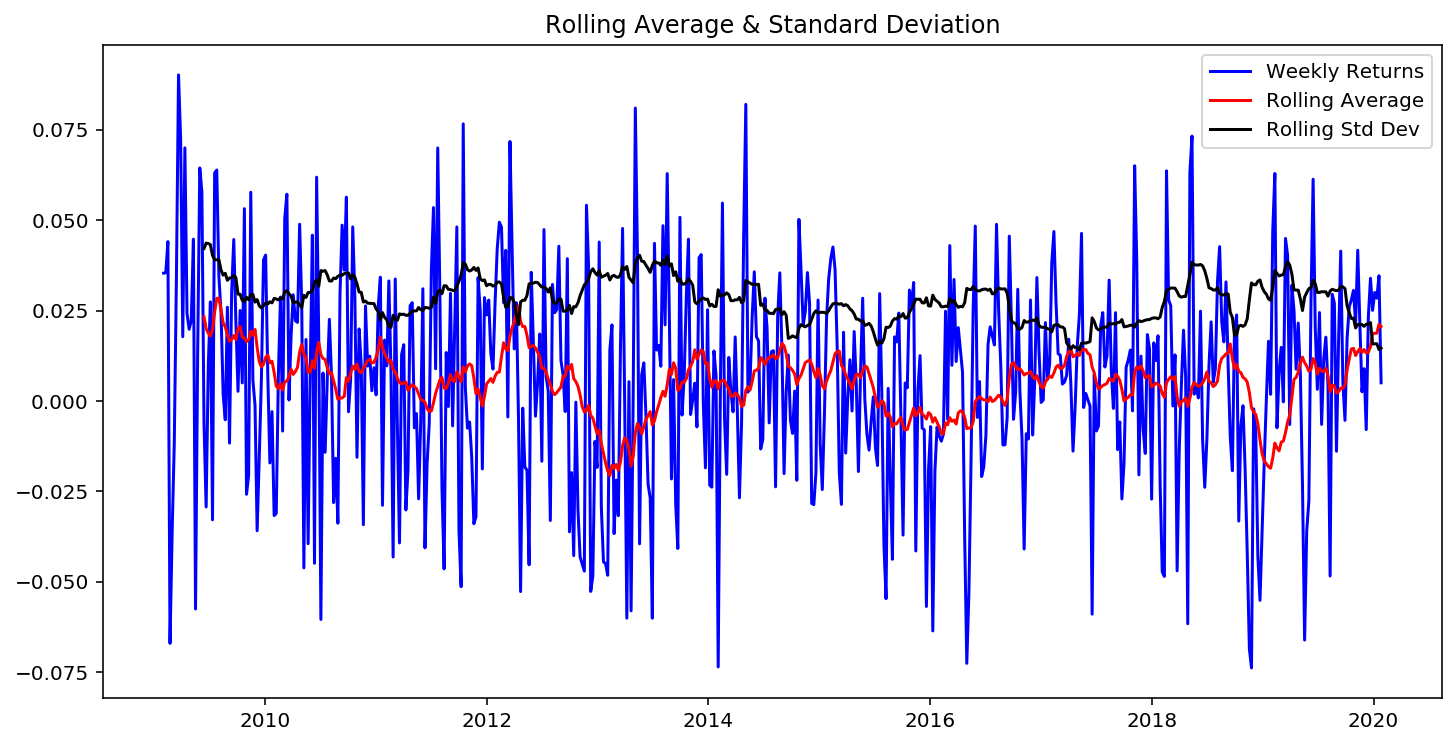

In [40]:
plt.figure(figsize=(12,6))

orig = plt.plot(udiff, color='blue', label='Weekly Returns')
avg = plt.plot(mov_avg, color='red', label='Rolling Average')
std = plt.plot(mov_std, color='black', label='Rolling Std Dev')

plt.title('Rolling Average & Standard Deviation')
plt.legend(loc='best')
plt.show()

In [44]:
# Performs the Dickey-Fuller test

dftest = sm.tsa.adfuller(udiff.Return, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used',
                                         'Number of Observations Used'])

for key, value in dftest[4].items():
    dfoutput['Critical VAlue ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.196033e+01
p-value                        4.116626e-22
#Lags Used                     2.000000e+00
Number of Observations Used    5.710000e+02
Critical VAlue (1%)           -3.441854e+00
Critical VAlue (5%)           -2.866615e+00
Critical VAlue (10%)          -2.569473e+00
dtype: float64

Because the p-value is below 0.05, we can conclude the data is stationary.

## ACF and PACF Charts

We're going to make some autocorrelation and partial autocorrelation charts to aid in choosing hyperparameters.

The ACF measures the correlation across time in our dataset. This corresponds to the hyper parameter 'q' in our ARIMA model.

The PACF is measures the partial correlation between two points separated by some number of lags. This corresponds to the hyperparameter 'p', describing the number of periods to lag in our autocorrelation.

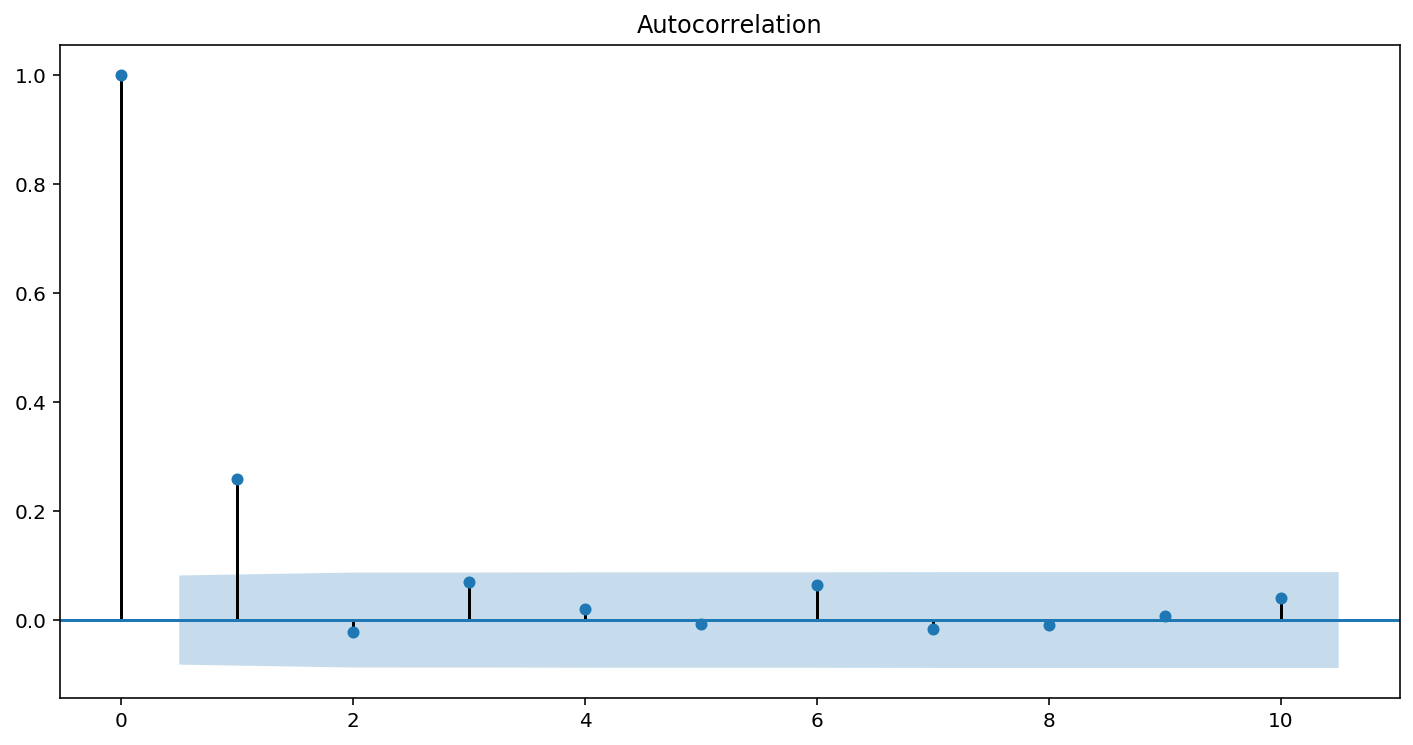

In [46]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(12,6))
plot_acf(udiff.values, lags=10, ax=ax)

plt.show()

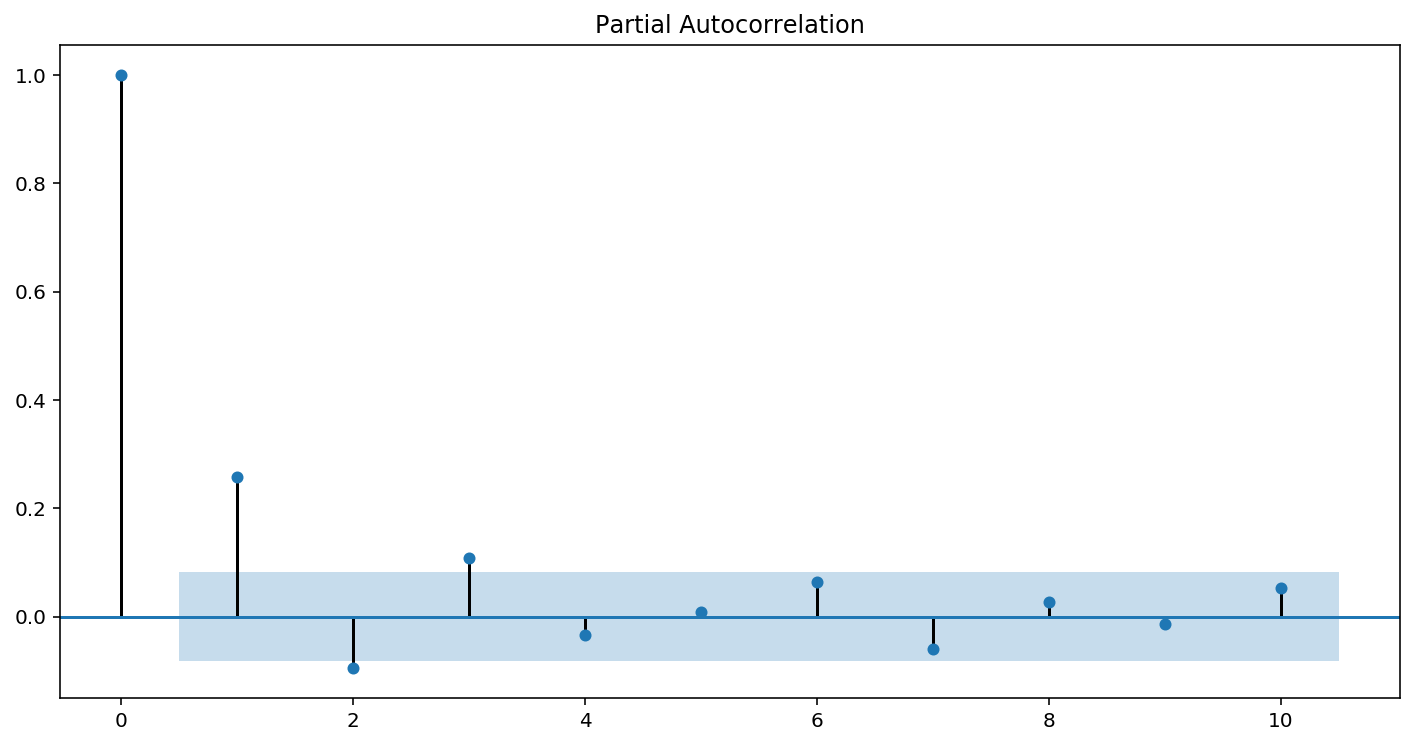

In [47]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,6))
plot_pacf(udiff.values, lags=10, ax=ax)

plt.show()

## ARIMA Model

Because we already differenced the data and it is stationary, we're going to use an ARMA model.

In [56]:
from statsmodels.tsa.arima_model import ARMA

arma = ARMA(tuple(udiff.values), (3,1)).fit()

arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  574
Model:                     ARMA(3, 1)   Log Likelihood                1237.502
Method:                       css-mle   S.D. of innovations              0.028
Date:                Wed, 22 Jan 2020   AIC                          -2463.003
Time:                        14:52:24   BIC                          -2436.887
Sample:                             0   HQIC                         -2452.817
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.002      3.707      0.000       0.003       0.009
ar.L1.y        0.0735      0.253      0.291      0.771      -0.422       0.569
ar.L2.y       -0.0628      0.083     -0.755      0.451      -0.226       0.100
ar.L3.y        0.0896      0.051      1.752      0.080      -0.011       0.190
ma.L1.y        0.2224      0.252      0.882      0.378      -0.272       0.717
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8290           -2.0111j            2.1752           -0.3122
AR.2           -0.8290           +2.0111j            2.1752            0.3122
AR.3            2.3590           -0.0000j            2.3590           -0.0000
MA.1           -4.4955           +0.0000j            4.4955            0.5000
-----------------------------------------------------------------------------
"""

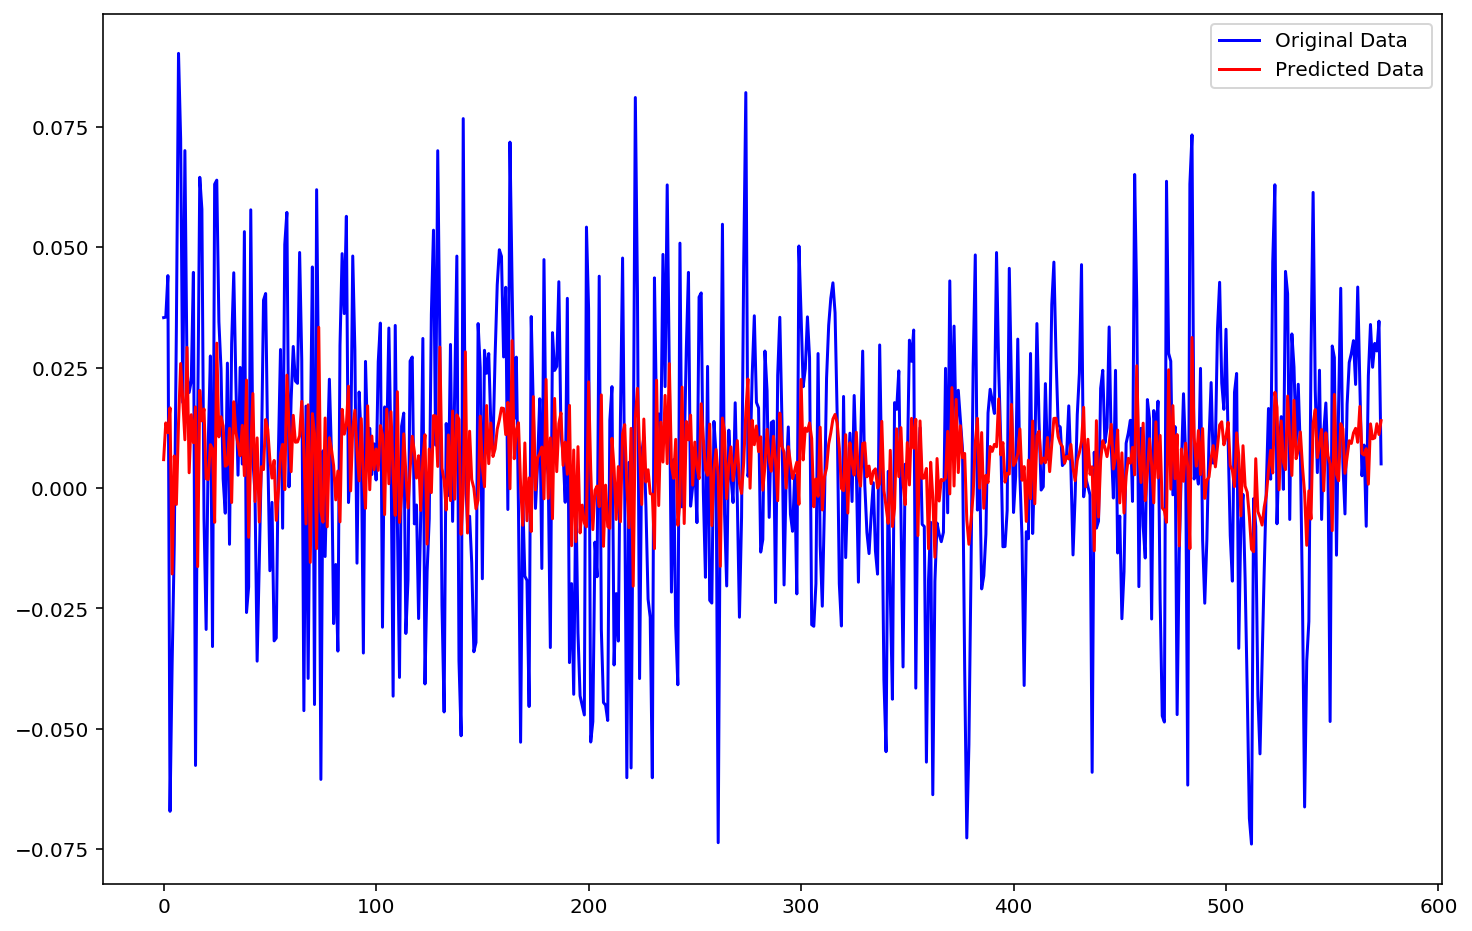

In [59]:
plt.figure(figsize=(12,8))
plt.plot(udiff.values, color='blue', label='Original Data')
preds = arma.fittedvalues
plt.plot(preds, color='red', label='Predicted Data')
plt.legend(loc='best')

plt.show()

While this particular model does a good job predicting direction, it is poor at predicting the magnitude of moves.

Below, we can try and make a price forecast 2 weeks into the future.

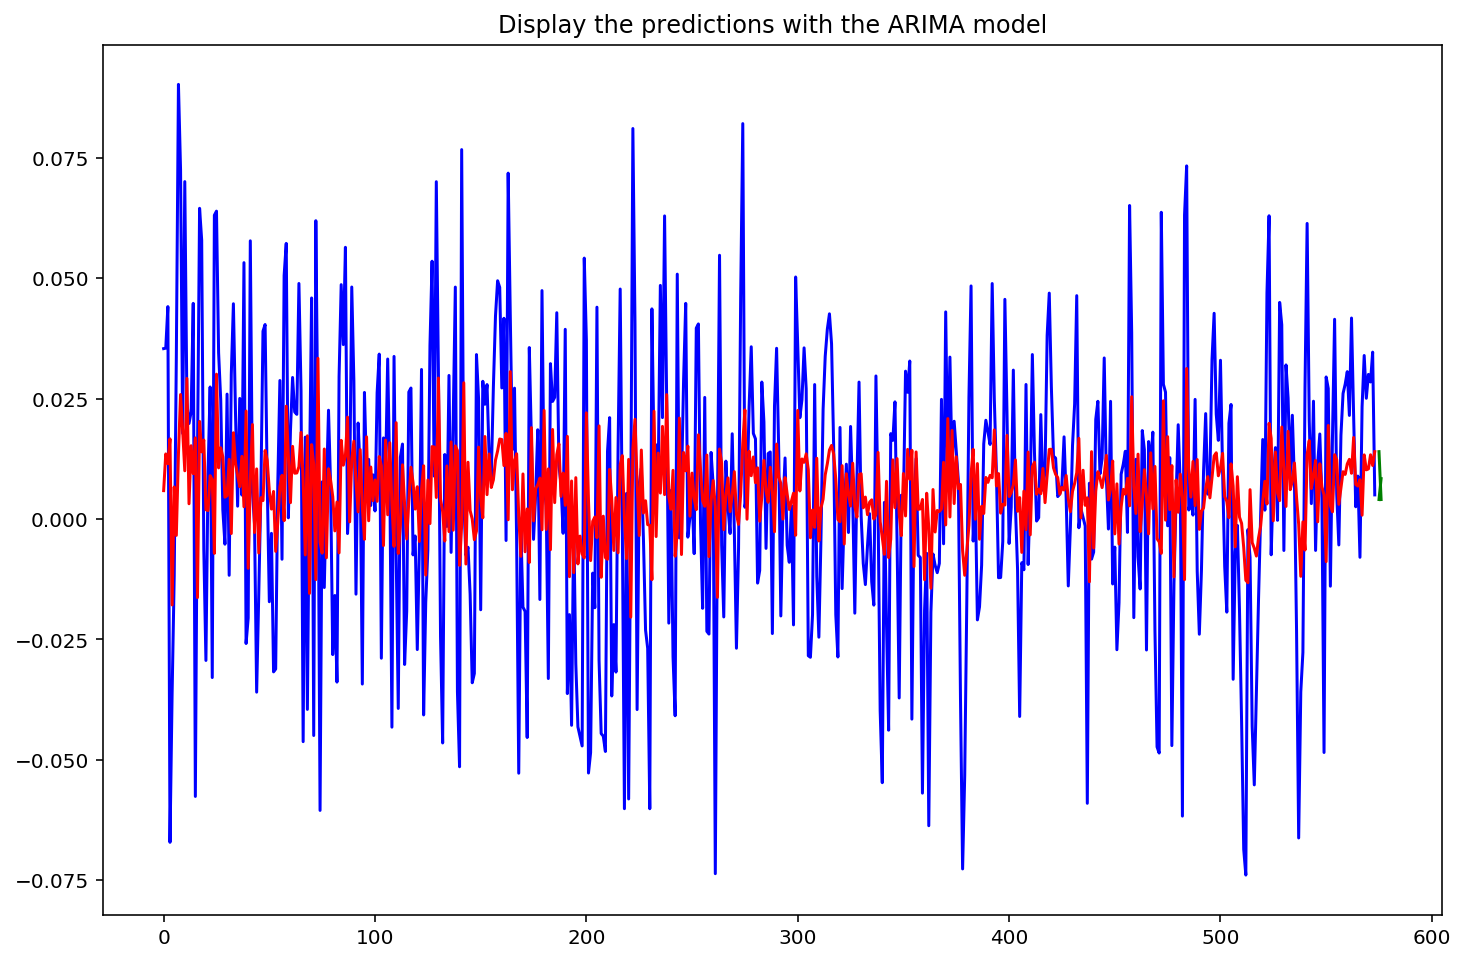

In [69]:
T = 2

forecast = arma.forecast(steps=T)[0]

plt.figure(figsize=(12,8))
plt.plot(udiff.values, color='blue', label='Original Data')
preds = arma.fittedvalues
plt.plot(preds, color='red', label='Predicted Data')

plt.plot(pd.DataFrame(np.array([preds[-1], forecast[0]]).T, index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast, index=range(len(udiff.values)+1, len(udiff.values)+1+T)), color='green')

plt.title('Display the predictions with the ARIMA model')

plt.show()